<h1 align=center><font size = 5><b>Diabetes prediction project</b></font></h1>

<h3 align=center><font size = 3><b>A project by Boris Y. Nedyalkov</b></font></h3>
<h3 align=center><font size = 3>With data from https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset</font></h3>

<center> <img src="https://maldita.es/uploads/images/2021/11/618e89365f697edittowfiqu-barbhuiya-zjak9jqxeda-unsplash-jpg.jpg" width=700, height=700 /></center> 

Image source: https://maldita.es/malditaciencia/20221114/preguntas-respuestas-diabetes/

### Notes:

* The data had many missing values, whcih were replaced by mean od KNN ML algorithm
* The data most likely refers to diabetes type 2 patients due to the insulin levels seen in part 2 of the project

################

* This data is unballanced, there are 2x more negative occurances then positive ones (ratio 2:1) - Thus we will forgo the use of ROC curves (which are to be used for balanced datasets) and instead use Precision-Recall curves (used in the case of imbalanced datasets) for the positive class (which is 1='has diabetes')
* "Average precision" (area under the Precision-Recall curve) would be the scoring metric we use here 
* Also we would like to (because its a medical test) to bias the model at the point of having minimal number of "False Negatives" for the positive class


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df = pd.read_csv("data_prepared_for_ML.csv")

In [3]:
# df = df.drop(['BloodPressure','SkinThickness'],axis=1)

In [4]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,334.2,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,56.2,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,32.2,238.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0.0
764,2.0,122.0,70.0,27.0,150.0,36.8,0.340,27.0,0.0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0.0
766,1.0,126.0,60.0,26.4,122.4,30.1,0.349,47.0,1.0


### Define some functions to be used later

In [5]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    plt.figure(figsize=(5, 3), dpi = 120)
    plot = sns.heatmap(cm, annot=True); #annot=True to annotate cells
    plot.set_xlabel('Predicted labels')
    plot.set_ylabel('True labels')
    plot.set_title('Confusion Matrix'); 
    plt.savefig('confusion_matrix', transparent=True, bbox_inches='tight')
    #ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show()
    
##########################################

def thresholds_tests (X_test, y_test, model):
    pred_proba_df = pd.DataFrame(model.predict_proba(X_test))
    threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    y_test = pd.DataFrame(y_test)
    for i in threshold_list:
        print ('\n******** For i = {} ******'.format(i))
        y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
        test_accuracy = accuracy_score(y_test.values.reshape(y_test.values.size,1),
                                               y_test_pred.iloc[:,1].values.reshape(y_test_pred.iloc[:,1].values.size,1))
        print('Our testing accuracy is {}'.format(test_accuracy))

        print(confusion_matrix(y_test.values.reshape(y_test.values.size,1),
                               y_test_pred.iloc[:,1].values.reshape(y_test_pred.iloc[:,1].values.size,1)))
        
##########################################
        
def manual_threshold_model(threshold_val, X_test, y_test, model):
    
    pred_proba_df = pd.DataFrame(model.predict_proba(X_test))
    y_test = pd.DataFrame(y_test)
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>threshold_val else 0)
    test_accuracy = accuracy_score(y_test.values.reshape(y_test.values.size,1),
                                           y_test_pred.iloc[:,1].values.reshape(y_test_pred.iloc[:,1].values.size,1))
    print('The testing accuracy is {}'.format(test_accuracy))
    
    y_pred = y_test_pred.iloc[:,1].values.reshape(y_test_pred.iloc[:,1].values.size,1)

    return y_pred

###########################################

def feature_importance_grader(model):
    
    importances = model.feature_importances_

    indices = np.argsort(importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(importances)), importances[indices])
    ax.set_yticks(range(len(importances)))
    _ = ax.set_yticklabels(np.array(df.columns)[indices])
    
########################################

def recall_precision_calc(X, Y, model, threshold):
    y_pred=manual_threshold_model(0.34, X, Y, best_random_xgboost)
    recall = float(classification_report(Y, y_pred)[137:141])
    precision = float(classification_report(y_test, y_pred)[128:132])
    
    return recall, precision

##########################################

from sklearn.model_selection import cross_val_score, KFold

def custom_cross_val_score(X_train, X_test, y_train, y_test, model, scoring):
    score=cross_val_score(model, X_train, y_train, cv=KFold(6, shuffle=True), scoring=scoring)
    print(' Train cross validation scores:',score,
          '\n Average score:',np.average(score),
          '\n Deviation of score:',np.std(score))

    score2=cross_val_score(model, X_test, y_test, cv=KFold(6, shuffle=True), scoring=scoring)
    print('\n Test cross validation scores:',score2,
          '\n Average score:',np.average(score2),
          '\n Deviation of score:',np.std(score2))
    
#######################################

def  PRplotter(y_train, y_proba_train, y_test, y_proba_test, name='name'):
    
    from sklearn.metrics import  precision_recall_curve

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=120)
    fig.suptitle('PR-plots')

    precision, recall, thresholds = precision_recall_curve(y_train,y_proba_train[:,1])
    sns.scatterplot(ax = ax1, x=recall, y=precision)
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('Train Data')

    precision2, recall2, thresholds2 = precision_recall_curve(y_test,y_proba_test[:,1])
    sns.scatterplot(ax = ax2, x=recall2, y=precision2)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Test Data')
    
    plt.show()
    
    # data ={'Recall_train':recall,
    #        'Prеcision_train':precision,
    #        'Recall_test':recall2,
    #        'Prеcision_test':precision2}
    # datafrtrain = pd.DataFrame('Recall_train':recall,
    #        'Prеcision_train':precision)
    
    return  precision, recall, precision2, recall2

### Split and normalize the data set

In [6]:
y = df['Outcome'].values
X_df = df.drop(['Outcome'], axis=1)
X = X_df.values

In [7]:
# standardize features 
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

# # normalize features 
# X = preprocessing.MinMaxScaler().fit(X).transform(X) 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4, shuffle=True)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (576, 8) (576,)
Test set: (192, 8) (192,)


## ML with Logistic Regression

### Logistic regression (untuned)

In [9]:
# import the classes
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

In [10]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16, class_weight='balanced')

# fit the model with data
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=16)

In [11]:
y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)
y_proba_test = logreg.predict_proba(X_test)
y_proba_train = logreg.predict_proba(X_train)

In [12]:
y_proba_train

array([[0.74101378, 0.25898622],
       [0.42740394, 0.57259606],
       [0.44196644, 0.55803356],
       ...,
       [0.45538495, 0.54461505],
       [0.9243398 , 0.0756602 ],
       [0.77822751, 0.22177249]])

In [13]:
print("LR's Train Accuracy: ", logreg.score(X_train, y_train))
print("LR's Test Accuracy: ", logreg.score(X_test, y_test))

LR's Train Accuracy:  0.7690972222222222
LR's Test Accuracy:  0.78125


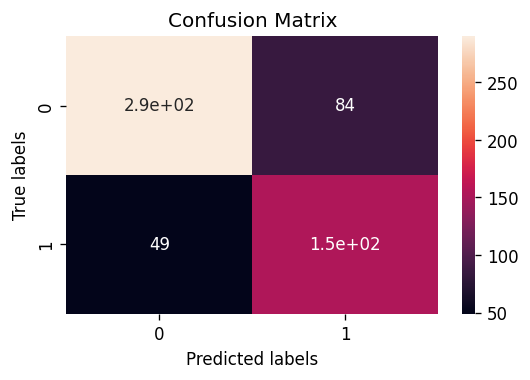

In [14]:
plot_confusion_matrix(y_train,y_pred_train)

In [15]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.86      0.78      0.81       374
         1.0       0.65      0.76      0.70       202

    accuracy                           0.77       576
   macro avg       0.75      0.77      0.76       576
weighted avg       0.78      0.77      0.77       576



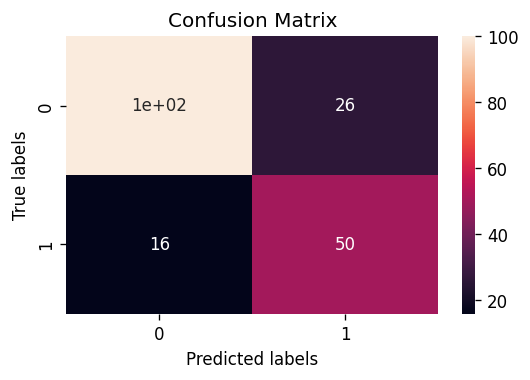

In [16]:
plot_confusion_matrix(y_test,y_pred_test)

In [17]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.86      0.79      0.83       126
         1.0       0.66      0.76      0.70        66

    accuracy                           0.78       192
   macro avg       0.76      0.78      0.77       192
weighted avg       0.79      0.78      0.78       192



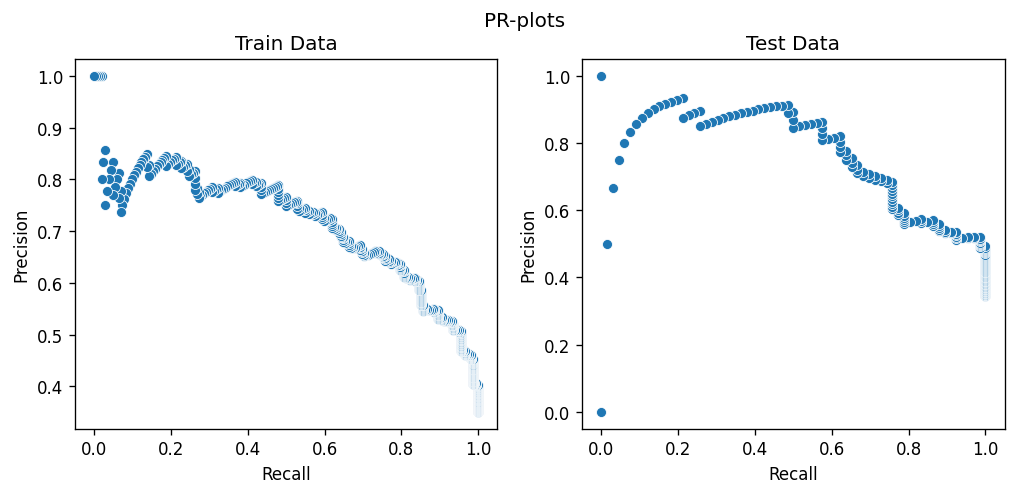

In [76]:
logreg_PR_plots = PRplotter(y_train, y_proba_train, y_test, y_proba_test, name='name')

In [ ]:
fpr, tpr, _ = roc_curve(y_test,y_proba[:,1])
plot = sns.scatterplot(x=fpr, y=tpr)
plot.set_xlabel('False positive')
plot.set_ylabel('True Positive')
plt.show()
roc_curve

In [72]:
custom_cross_val_score(X_train, X_test, y_train, y_test, model=logreg, scoring='average_precision')

 Train cross validation scores: [0.74994148 0.78363583 0.75504181 0.74139871 0.67467418 0.59034044] 
 Average score: 0.7158387399394911 
 Deviation of score: 0.06505635935175523

 Test cross validation scores: [0.79213236 0.80757144 0.83062628 0.40737179 0.92709929 0.67857143] 
 Average score: 0.7405620988234841 
 Deviation of score: 0.165789045534611


In [ ]:
thresholds_tests (X_train, y_train, logreg)

### Hyperparameter tuning of Logistic Regression

In [73]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [83]:
model = LogisticRegression(class_weight='balanced')
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='average_precision', error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.720340 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.718386 (0.069959) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.718386 (0.069959) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.718386 (0.069959) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.718498 (0.069914) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.718498 (0.069914) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.718498 (0.069914) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.718123 (0.070499) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.718134 (0.070493) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.718245 (0.070510) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.720173 (0.070780) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.720173 (0.070780) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.720340 (0.070740) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.716889 (0.061699) wit

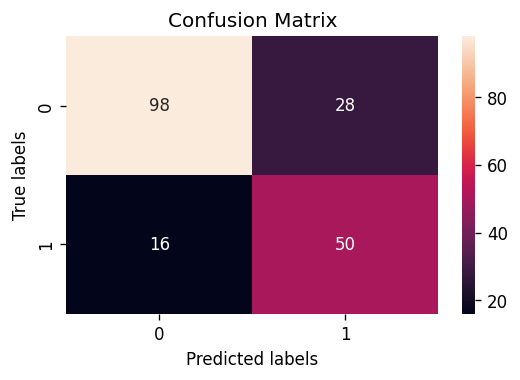

In [84]:
y_pred_test = grid_search.predict(X_test)
y_proba_test = grid_search.predict_proba(X_test)
y_pred_train = grid_search.predict(X_train)
y_proba_train = grid_search.predict_proba(X_train)
plot_confusion_matrix(y_test,y_pred)

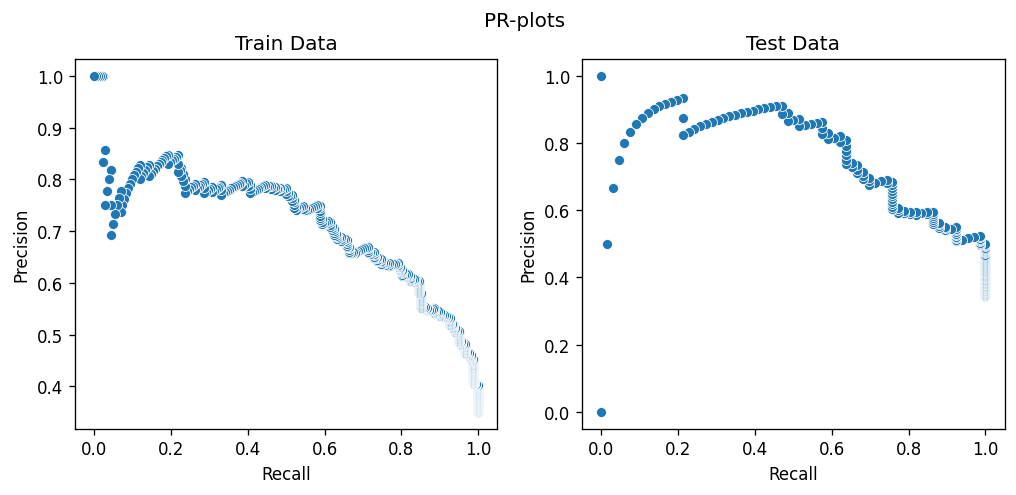

In [85]:
logreg_PR_plots = PRplotter(y_train, y_proba_train, y_test, y_proba_test, name='name')

In [86]:
custom_cross_val_score(X_train, X_test, y_train, y_test, model=grid_search, scoring='average_precision')

 Train cross validation scores: [0.76176057 0.49523464 0.81703663 0.71324238 0.72091311 0.76621689] 
 Average score: 0.712400702363019 
 Deviation of score: 0.10288790374731022

 Test cross validation scores: [0.82054067 0.52087542 0.68107546 0.90637141 1.         0.88820217] 
 Average score: 0.8028441884236915 
 Deviation of score: 0.15891373923796923


In [ ]:
thresholds_tests (X_test, y_test, grid_search)

#### Roughly the same output as the simple LR

### Hyperparameter tuning of Ridge Classifier

In [88]:
from sklearn.linear_model import RidgeClassifier

In [89]:
ridgeclass = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=ridgeclass, param_grid=grid, n_jobs=-1, cv=cv, scoring='average_precision',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.718941 using {'alpha': 1.0}
0.718334 (0.072344) with: {'alpha': 0.1}
0.718361 (0.072350) with: {'alpha': 0.2}
0.718555 (0.072546) with: {'alpha': 0.3}
0.718555 (0.072546) with: {'alpha': 0.4}
0.718546 (0.072544) with: {'alpha': 0.5}
0.718546 (0.072544) with: {'alpha': 0.6}
0.718497 (0.072493) with: {'alpha': 0.7}
0.718497 (0.072493) with: {'alpha': 0.8}
0.718520 (0.072465) with: {'alpha': 0.9}
0.718941 (0.072574) with: {'alpha': 1.0}


#### Roughly the same output as the simple LR

## ML with Random forest 

### Random forest (untuned)

In [90]:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(class_weight="balanced")

rforest.fit(X_train, y_train)

print(f'model score on training data: {rforest.score(X_train, y_train)}')
print(f'model score on testing data: {rforest.score(X_test, y_test)}')

model score on training data: 1.0
model score on testing data: 0.8020833333333334


In [91]:
rforest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [92]:
y_pred_test = rforest.predict(X_test)
y_proba_test = rforest.predict_proba(X_test)
y_pred_train = rforest.predict(X_train)
y_proba_train = rforest.predict_proba(X_train)

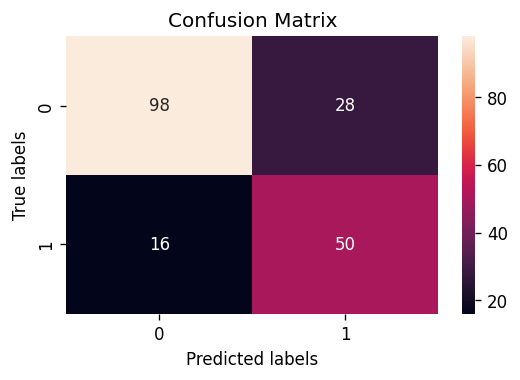

              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82       126
         1.0       0.64      0.76      0.69        66

    accuracy                           0.77       192
   macro avg       0.75      0.77      0.76       192
weighted avg       0.78      0.77      0.77       192



In [93]:
plot_confusion_matrix(y_test,y_pred)
print(classification_report(y_test, y_pred))

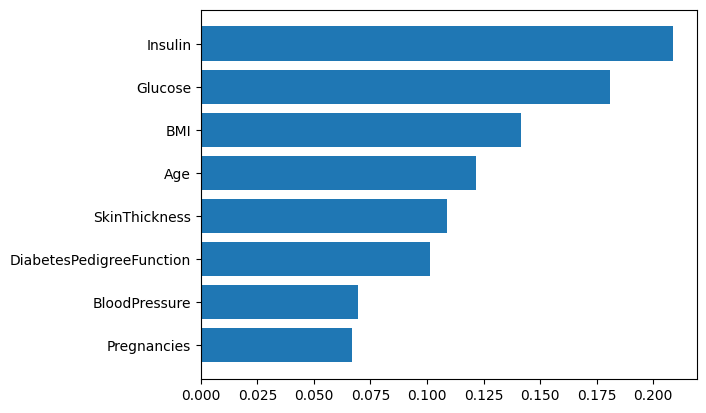

In [94]:
feature_importance_grader(model=rforest)

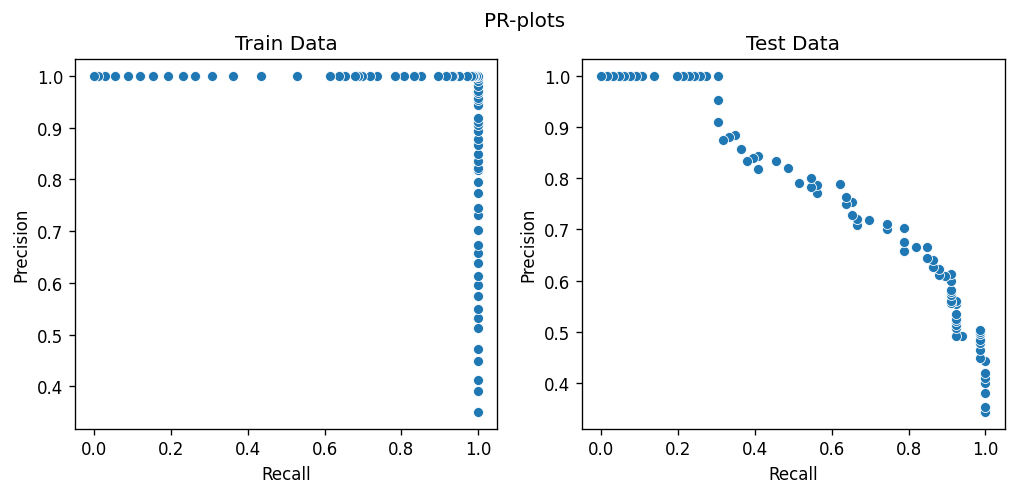

In [95]:
rforest_PR_plots = PRplotter(y_train, y_proba_train, y_test, y_proba_test, name='name')

In [98]:
custom_cross_val_score(X_train, X_test, y_train, y_test, model=rforest, scoring='average_precision')

 Train cross validation scores: [0.87988338 0.78499449 0.63347638 0.71044986 0.74085671 0.72348275] 
 Average score: 0.7455239286536894 
 Deviation of score: 0.07516961382027973

 Test cross validation scores: [0.89436665 0.70791183 0.66666667 0.86349206 0.817438   0.75029133] 
 Average score: 0.7833610893869537 
 Deviation of score: 0.08196364342600063


#### Did a bit better then the linear regressions (more precision for maximum recall)

In [ ]:
thresholds_tests (X_test, y_test, rforest)

### Random forest (hypertuned)

First we starts with rough random search

In [99]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1800, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [100]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight="balanced", random_state = 16)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='average_precision', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Smelly_Giraffe\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [101]:
rf_random.best_params_

{'n_estimators': 477,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': True}

In [105]:
best_random_rforest = rf_random.best_estimator_

In [106]:
print(f'model score on training data: {best_random.score(X_train, y_train)}')
print(f'model score on testing data: {best_random.score(X_test, y_test)}')

model score on training data: 0.921875
model score on testing data: 0.796875


In [120]:
y_pred_test = best_random_rforest.predict(X_test)
y_proba_test = best_random_rforest.predict_proba(X_test)
y_pred_train = best_random_rforest.predict(X_train)
y_proba_train = best_random_rforest.predict_proba(X_train)

In [121]:
custom_cross_val_score(X_train, X_test, y_train, y_test, model=best_random_rforest, scoring='average_precision')

C:\Users\Smelly_Giraffe\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Smelly_Giraffe\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Smelly_Giraffe\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set

 Train cross validation scores: [0.64701787 0.76831647 0.78086949 0.68803406 0.63974094 0.72811936] 
 Average score: 0.7086830336413401 
 Deviation of score: 0.05496481897923667


C:\Users\Smelly_Giraffe\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Smelly_Giraffe\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Smelly_Giraffe\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set


 Test cross validation scores: [0.9096702  0.85995671 0.81133157 0.47809454 0.6612685  0.90738508] 
 Average score: 0.7712844315326909 
 Deviation of score: 0.1555658324948499


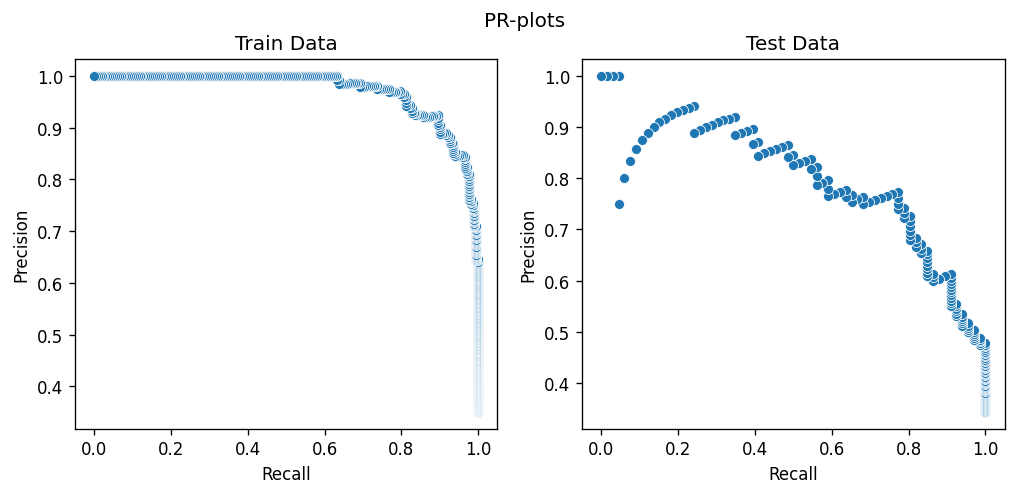

In [122]:
rforest_PR_plots = PRplotter(y_train, y_proba_train, y_test, y_proba_test, name='name')

Let us see how the grid search can fine tune this

In [516]:
from sklearn.model_selection import GridSearchCV

In [517]:
# Number of trees in random forest
n_estimators = [800, 1000, 1200]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [40, 50, 60, 70]
# Minimum number of samples required to split a node
min_samples_split = [2, 3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid,
                              scoring='average_precision', 
                              cv = 3, n_jobs=-1,
                              return_train_score=True)

# Fit the grid search model
rf_grid.fit(X_train, y_train);

In [518]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [519]:
best_grid = rf_grid.best_estimator_

In [520]:
print(f'model score on training data: {best_random.score(X_train, y_train)}')
print(f'model score on testing data: {best_random.score(X_test, y_test)}')

model score on training data: 0.9826388888888888
model score on testing data: 0.8020833333333334


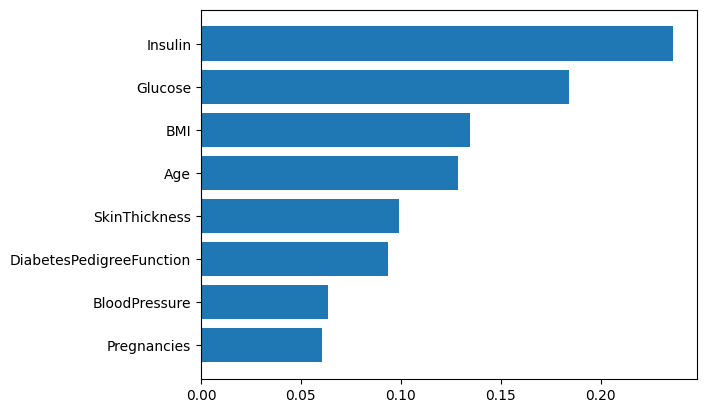

In [521]:
importances = best_random.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(df.columns)[indices])

In [ ]:
thresholds_tests (X_test, y_test, best_random)

## ML with XGBoost

### XGBoost (untuned)

In [110]:
import xgboost

In [111]:
xgboost_classifier = xgboost.XGBClassifier()

xgboost_classifier.fit(X_train, y_train)

print(f'model score on training data: {xgboost_classifier.score(X_train, y_train)}')
print(f'model score on testing data: {xgboost_classifier.score(X_test, y_test)}')

model score on training data: 1.0
model score on testing data: 0.7864583333333334


In [112]:
xgboost_classifier.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [114]:
y_pred_test = xgboost_classifier.predict(X_test)
y_proba_test = xgboost_classifier.predict_proba(X_test)
y_pred_train = xgboost_classifier.predict(X_train)
y_proba_train = xgboost_classifier.predict_proba(X_train)

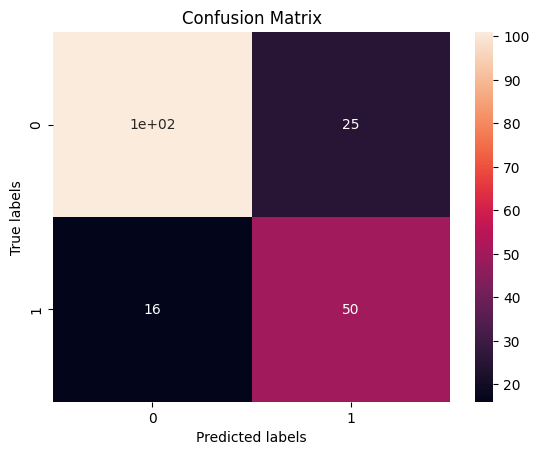

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83       126
         1.0       0.67      0.76      0.71        66

    accuracy                           0.79       192
   macro avg       0.76      0.78      0.77       192
weighted avg       0.80      0.79      0.79       192



In [527]:
plot_confusion_matrix(y_test,y_pred)
print(classification_report(y_test, y_pred))

In [118]:
custom_cross_val_score(X_train, X_test, y_train, y_test, model=xgboost_classifier, scoring='average_precision')

 Train cross validation scores: [0.61792685 0.70184134 0.69738678 0.69523447 0.62209532 0.85383022] 
 Average score: 0.6980524981045803 
 Deviation of score: 0.07797334121657334

 Test cross validation scores: [0.80296635 0.74670996 0.66040564 0.6067051  0.88713023 0.94011373] 
 Average score: 0.7740051693392798 
 Deviation of score: 0.11752111744055756


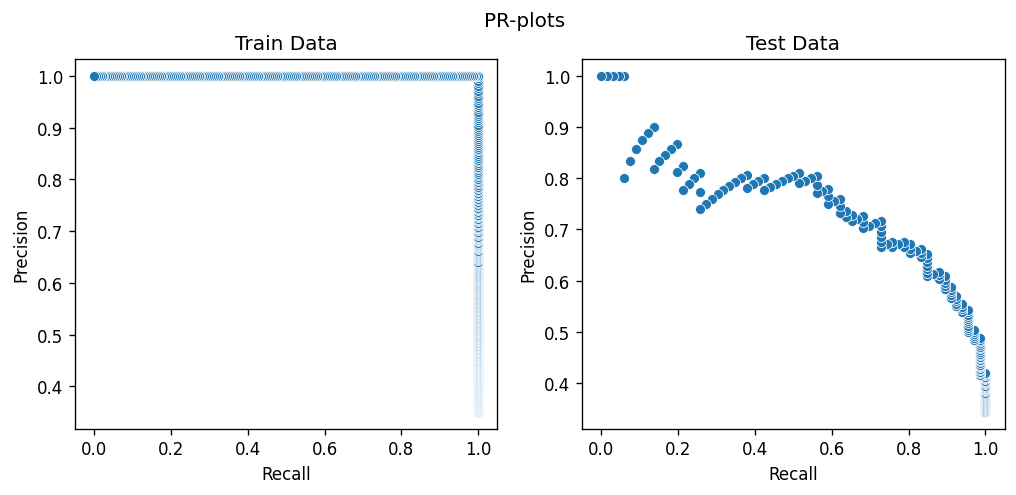

In [119]:
xgboost_PR_plots = PRplotter(y_train, y_proba_train, y_test, y_proba_test, name='name')

### XGBoost (hyperparameter-tuned)

In [194]:
params = {
 'n_estimators' : [100],
 'learning_rate' : [0.05,0.1],
 'max_depth' : [ 5, 6, 8, 10],
 'min_child_weight' : [ 1, 2, 3, 5 ],
 'gamma': [ 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.4, 0.5 , 0.7, 0.9 ]
}

In [195]:
rs_model=RandomizedSearchCV(xgboost_classifier,
                            param_distributions=params,
                            n_iter=100,scoring='roc_auc',
                            n_jobs=-1,
                            cv=5,
                            verbose=3)

In [196]:
#model fitting
rs_model.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.4, 0.5, 0.7,
                                                             0.9],
                                        'gamma': [0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [5, 6, 8, 10],
                                        'min_child_weight': [1, 2, 3, 5],
                                        'n_estimators': [100]},
                   scoring='roc_auc', verbose=3)

In [197]:
# best parameters selected
best_random_xgboost = rs_model.best_estimator_
best_random_xgboost

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [198]:
from sklearn.model_selection import cross_val_score, KFold

score=cross_val_score(best_random_xgboost,X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('Train cross validation scores:',score)

score=cross_val_score(best_random_xgboost,X_test, y_test, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('Tests cross validation scores:',score)

Train cross validation scores: [0.85539216 0.83779762 0.84341085 0.88322981 0.86418269 0.88695652
 0.80434783 0.87541528 0.76067073 0.79480519]
Tests cross validation scores: [0.93406593 0.90625    0.88571429 0.80952381 0.67142857 0.76190476
 0.89772727 0.93333333 0.91666667 0.96590909]


In [199]:
print(f'model score on training data: {best_random_xgboost.score(X_train, y_train)}')
print(f'model score on testing data: {best_random_xgboost.score(X_test, y_test)}')

model score on training data: 0.9184027777777778
model score on testing data: 0.953125


In [200]:
y_pred_test = best_random_xgboost.predict(X_test)
y_proba_test = best_random_xgboost.predict_proba(X_test)
y_pred_train = best_random_xgboost.predict(X_train)
y_proba_train = best_random_xgboost.predict_proba(X_train)

In [201]:
custom_cross_val_score(X_train, X_test, y_train, y_test, model=best_random_xgboost, scoring='average_precision')

 Train cross validation scores: [0.69753943 0.72651385 0.61971799 0.84143145 0.58344366 0.69127583] 
 Average score: 0.6933203666124482 
 Deviation of score: 0.08220997550637428

 Test cross validation scores: [0.5777124  0.8553942  0.9260101  0.7403367  0.6720272  0.89775641] 
 Average score: 0.7782061696487202 
 Deviation of score: 0.12583194800600916


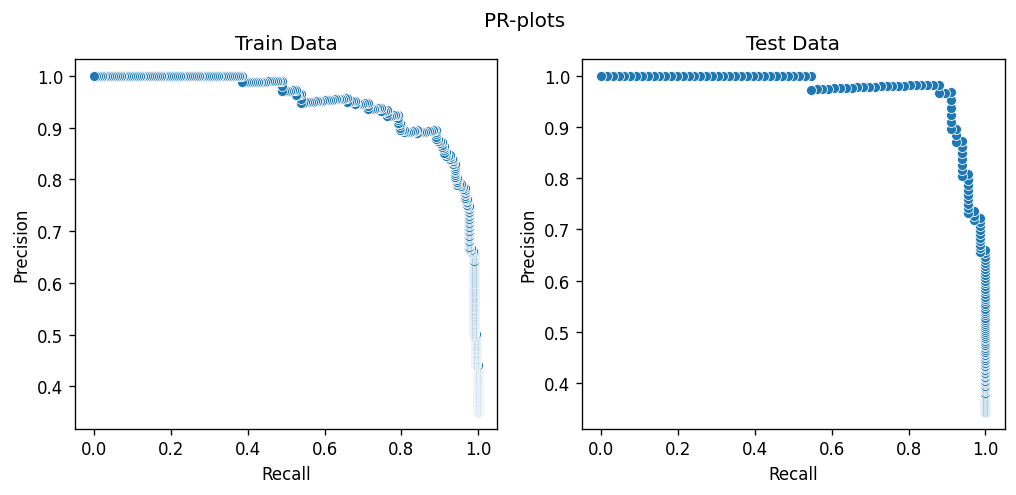

In [202]:
xgboost_PR_plots = PRplotter(y_train, y_proba_train, y_test, y_proba_test, name='name')

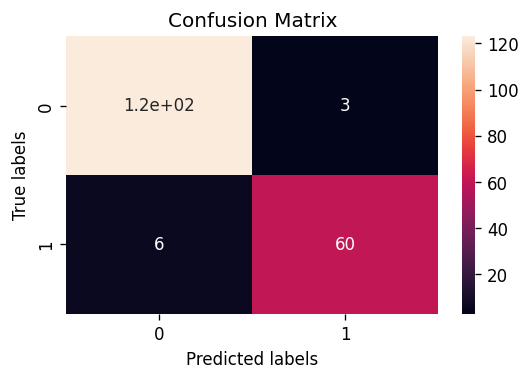

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       126
         1.0       0.95      0.91      0.93        66

    accuracy                           0.95       192
   macro avg       0.95      0.94      0.95       192
weighted avg       0.95      0.95      0.95       192



In [203]:
y_pred = best_random_xgboost.predict(X_test)
# y_proba = best_random_xgboost.predict_proba(X_test)

plot_confusion_matrix(y_test,y_pred)
print(classification_report(y_test, y_pred))

In [204]:
thresholds_tests (X_test, y_test, best_random_xgboost)


******** For i = 0.05 ******
Our testing accuracy is 0.6197916666666666
[[53 73]
 [ 0 66]]

******** For i = 0.1 ******
Our testing accuracy is 0.6927083333333334
[[67 59]
 [ 0 66]]

******** For i = 0.15 ******
Our testing accuracy is 0.7447916666666666
[[77 49]
 [ 0 66]]

******** For i = 0.2 ******
Our testing accuracy is 0.8020833333333334
[[88 38]
 [ 0 66]]

******** For i = 0.25 ******
Our testing accuracy is 0.8333333333333334
[[95 31]
 [ 1 65]]

******** For i = 0.3 ******
Our testing accuracy is 0.8645833333333334
[[102  24]
 [  2  64]]

******** For i = 0.35 ******
Our testing accuracy is 0.875
[[105  21]
 [  3  63]]

******** For i = 0.4 ******
Our testing accuracy is 0.90625
[[111  15]
 [  3  63]]

******** For i = 0.45 ******
Our testing accuracy is 0.9270833333333334
[[116  10]
 [  4  62]]

******** For i = 0.5 ******
Our testing accuracy is 0.953125
[[123   3]
 [  6  60]]

******** For i = 0.55 ******
Our testing accuracy is 0.9479166666666666
[[125   1]
 [  9  57]]

**

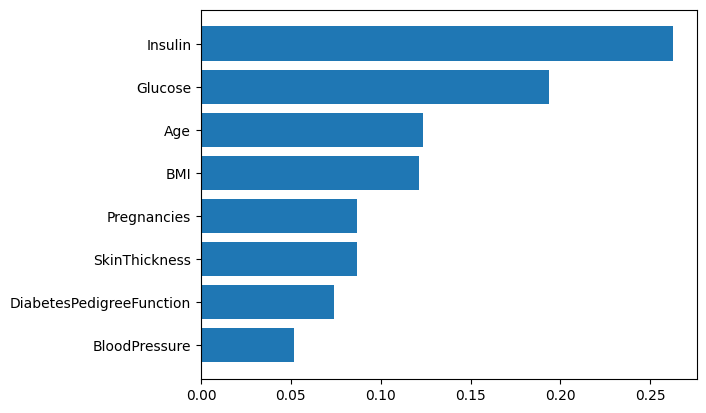

In [205]:
feature_importance_grader(best_random_xgboost)

The testing accuracy is 0.9479166666666666


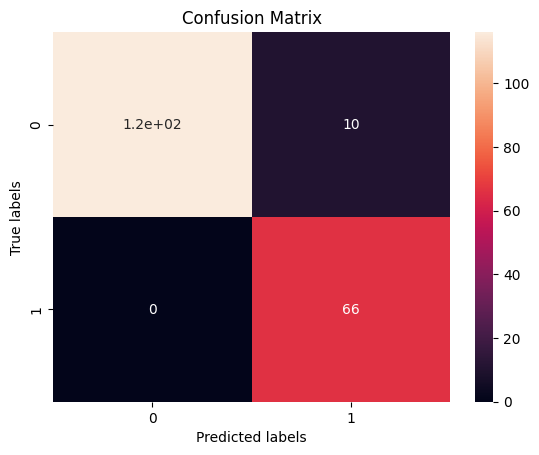

In [611]:
y_pred=manual_threshold_model(0.34, X_test, y_test, best_random_xgboost)
plot_confusion_matrix(y_test,y_pred)

### XGBoost Grid Search

In [595]:
XG_grid = GridSearchCV(xgboost_classifier,
                        param_grid=params,
                        scoring='average_precision',
                        n_jobs=-1,
                        cv=4,
                        verbose=3)

#model fitting
XG_grid.fit(X,y)

Fitting 4 folds for each of 7200 candidates, totalling 28800 fits


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.7, 0.9],
                         'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'learning_rate': [0.03, 0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5, 6, 8, 10],
                         'min_child_weight': [1, 2, 3, 5],
                         'n_estimators': [50, 100, 300]},
             scoring='roc_auc', verbose=3)

In [596]:
# best parameters selected
best_grid_xgboost = XG_grid.best_estimator_
best_grid_xgboost

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [597]:
from sklearn.model_selection import cross_val_score, KFold

score=cross_val_score(best_grid_xgboost,X_train, y_train, cv=KFold(shuffle=True), scoring='roc_auc')
print('Train cross validation scores:',score)

score=cross_val_score(best_grid_xgboost,X_test, y_test, cv=KFold(shuffle=True), scoring='roc_auc')
print('Tests cross validation scores:',score)

Train cross validation scores: [0.84137709 0.82770745 0.82003955 0.90519568 0.81978233]
Tests cross validation scores: [0.91142857 0.88636364 0.8013468  0.82102273 0.97321429]


In [598]:
print(f'model score on training data: {best_grid_xgboost.score(X_train, y_train)}')
print(f'model score on testing data: {best_grid_xgboost.score(X_test, y_test)}')

model score on training data: 0.8888888888888888
model score on testing data: 0.9114583333333334


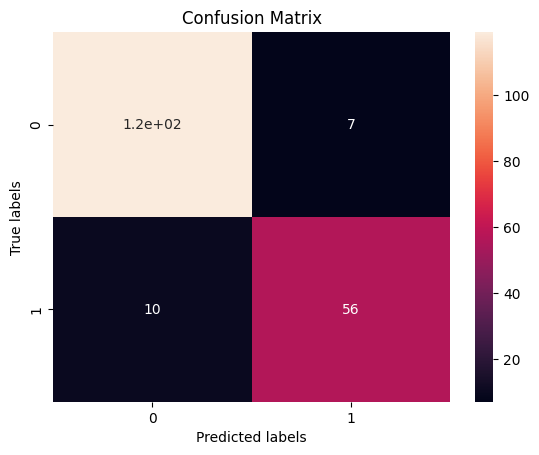

              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       126
         1.0       0.89      0.85      0.87        66

    accuracy                           0.91       192
   macro avg       0.91      0.90      0.90       192
weighted avg       0.91      0.91      0.91       192



In [599]:
y_pred = best_grid_xgboost.predict(X_test)
y_proba = best_grid_xgboost.predict_proba(X_test)

plot_confusion_matrix(y_test,y_pred)
print(classification_report(y_test, y_pred))

In [603]:
thresholds_tests (X_train, y_test, best_grid_xgboost)


******** For i = 0.05 ******
Our testing accuracy is 0.34375
[[  0 126]
 [  0  66]]

******** For i = 0.1 ******
Our testing accuracy is 0.5885416666666666
[[47 79]
 [ 0 66]]

******** For i = 0.15 ******
Our testing accuracy is 0.6822916666666666
[[65 61]
 [ 0 66]]

******** For i = 0.2 ******
Our testing accuracy is 0.7291666666666666
[[74 52]
 [ 0 66]]

******** For i = 0.25 ******
Our testing accuracy is 0.7760416666666666
[[84 42]
 [ 1 65]]

******** For i = 0.3 ******
Our testing accuracy is 0.828125
[[95 31]
 [ 2 64]]

******** For i = 0.35 ******
Our testing accuracy is 0.8541666666666666
[[101  25]
 [  3  63]]

******** For i = 0.4 ******
Our testing accuracy is 0.890625
[[109  17]
 [  4  62]]

******** For i = 0.45 ******
Our testing accuracy is 0.9010416666666666
[[113  13]
 [  6  60]]

******** For i = 0.5 ******
Our testing accuracy is 0.9114583333333334
[[119   7]
 [ 10  56]]

******** For i = 0.55 ******
Our testing accuracy is 0.921875
[[124   2]
 [ 13  53]]

******** 

Conclusion - XGBoost gives us the best model by a big margin
Though surprisingly the random search worked much better then the grid search, for the same hyperparametrs

## Making sure we have a stable Recall rate 

In [ ]:
# best_random_xgboost = 

The best threshold value we find for minimum recall is 0.34 on the Random Search tuned XGBoost

GBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [701]:
y_pred=manual_threshold_model(0.34, X_test, y_test, best_random_xgboost)

The testing accuracy is 0.9479166666666666


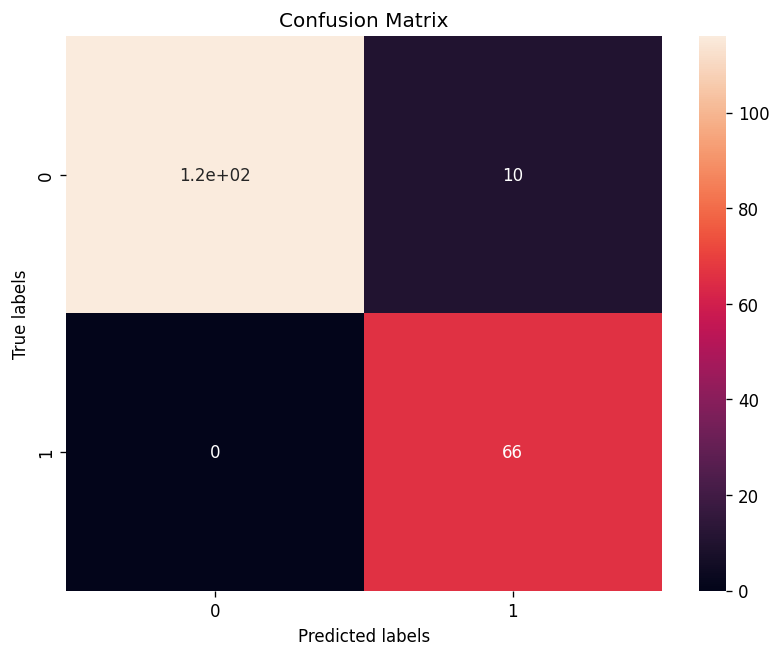

In [702]:
plot_confusion_matrix(y_test,y_pred)

In [703]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96       126
         1.0       0.87      1.00      0.93        66

    accuracy                           0.95       192
   macro avg       0.93      0.96      0.94       192
weighted avg       0.95      0.95      0.95       192



In [653]:
recall = float(classification_report(y_test, y_pred)[137:141])
recall
precision = float(classification_report(y_test, y_pred)[128:132])
precision

0.87

In [658]:
recall_precision_calc(X=X_test, Y=y_test, model=best_random_xgboost, threshold=0.34)

The testing accuracy is 0.9479166666666666


(1.0, 0.87)

# Plot the results

In [ ]:
# model_dict = {
#     'Simple LogReg':
#     'Tuned LogReg':
#     'Tunded RidgeClass':
#     'Simple RandomForest':
#     'Tuned RandomForest':
#     'Simple XGBoost':
#     'RandSearch XGBoost':
#     'Grid XGBoost':1.00,0.87
#              }

In [131]:
# fpr, tpr, _ = roc_curve(y_test,y_proba[:,1])

# plt.figure(figsize=(9, 6), dpi = 100)
# plot = sns.lineplot(x=fpr, y=tpr, linewidth = 3) 
# plot.set_xlabel("False positive", fontsize=22)
# plot.set_ylabel("True Positive", fontsize=22)
# plot.tick_params(labelsize=17)
# plt.savefig('ROC', transparent=True, bbox_inches='tight')
# plt.show() 

In [132]:
# precision, recall, thresholds = precision_recall_curve(y_test,y_proba[:,1])

# plot = sns.lineplot(x=recall, y=precision)
# plot.set_xlabel('Recall')
# plot.set_ylabel('Precision')
# plt.show()

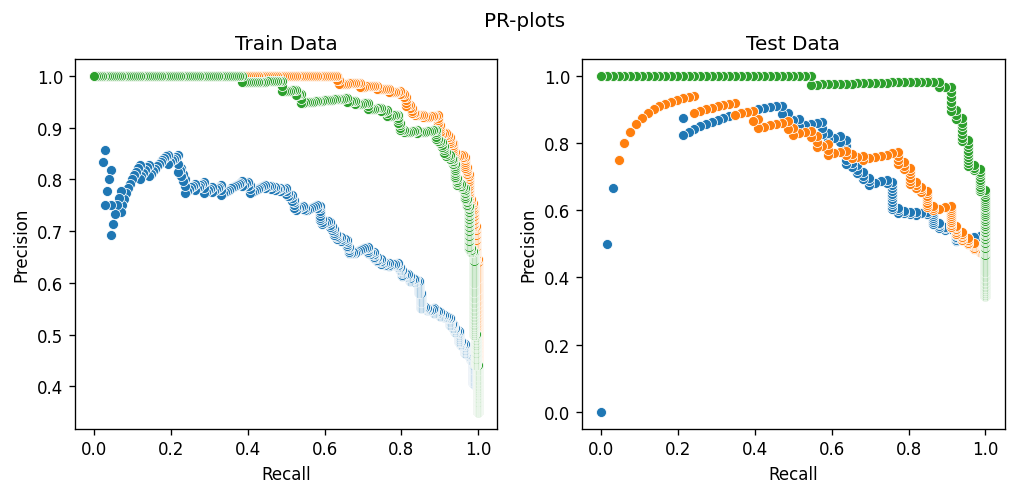

In [212]:
rforest_PR_plots
xgboost_PR_plots
logreg_PR_plots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=120)
fig.suptitle('PR-plots')

sns.scatterplot(ax = ax1, x=logreg_PR_plots[1], y=logreg_PR_plots[0])
sns.scatterplot(ax = ax1, x=rforest_PR_plots[1], y=rforest_PR_plots[0])
sns.scatterplot(ax = ax1, x=xgboost_PR_plots[1], y=xgboost_PR_plots[0])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Train Data')

sns.scatterplot(ax = ax2, x=logreg_PR_plots[3], y=logreg_PR_plots[2])
sns.scatterplot(ax = ax2, x=rforest_PR_plots[3], y=rforest_PR_plots[2])
sns.scatterplot(ax = ax2, x=xgboost_PR_plots[3], y=xgboost_PR_plots[2])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Test Data')

plt.savefig('PR-plots', transparent=True, bbox_inches='tight')    
plt.show()

In [207]:
thresholds_tests (X_test, y_test, best_random_xgboost)


******** For i = 0.05 ******
Our testing accuracy is 0.6197916666666666
[[53 73]
 [ 0 66]]

******** For i = 0.1 ******
Our testing accuracy is 0.6927083333333334
[[67 59]
 [ 0 66]]

******** For i = 0.15 ******
Our testing accuracy is 0.7447916666666666
[[77 49]
 [ 0 66]]

******** For i = 0.2 ******
Our testing accuracy is 0.8020833333333334
[[88 38]
 [ 0 66]]

******** For i = 0.25 ******
Our testing accuracy is 0.8333333333333334
[[95 31]
 [ 1 65]]

******** For i = 0.3 ******
Our testing accuracy is 0.8645833333333334
[[102  24]
 [  2  64]]

******** For i = 0.35 ******
Our testing accuracy is 0.875
[[105  21]
 [  3  63]]

******** For i = 0.4 ******
Our testing accuracy is 0.90625
[[111  15]
 [  3  63]]

******** For i = 0.45 ******
Our testing accuracy is 0.9270833333333334
[[116  10]
 [  4  62]]

******** For i = 0.5 ******
Our testing accuracy is 0.953125
[[123   3]
 [  6  60]]

******** For i = 0.55 ******
Our testing accuracy is 0.9479166666666666
[[125   1]
 [  9  57]]

**

The testing accuracy is 0.8229166666666666


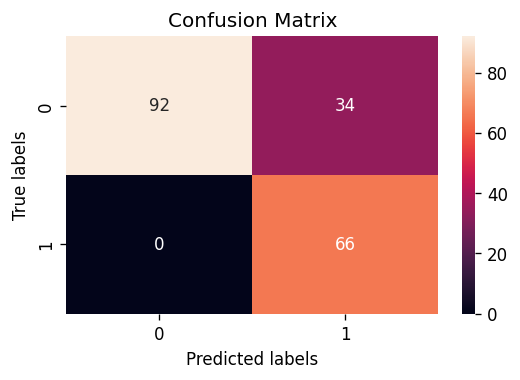

In [211]:
y_predict = manual_threshold_model(0.23, X_test, y_test, model=best_random_xgboost)
plot_confusion_matrix(y_test,y_predict)

# *The End*